In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit


import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
tf.__version__

Using TensorFlow backend.


'1.13.1'

In [2]:
# Helper Functions

def get1hot(y_train,y_test):
    from sklearn.preprocessing import OneHotEncoder

    enc = OneHotEncoder(categories="auto", sparse=False)
    y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
    y_test_1hot = enc.fit_transform([[label] for label in y_test])

    return y_train_1hot, y_test_1hot

def get_split(features, labels):
    
    # The train set will have equal amounts of each target class
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(features, labels):
        X_train = features[train_index]
        y_train = labels.iloc[train_index]
        X_test = features[test_index]
        y_test = labels.iloc[test_index]
        
        yield X_train, y_train, X_test, y_test

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    
    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    
    plt.show()
    

def remove_label(features, labels, label="MCI"):
    labels = pd.Series(fused_labels)
    non_samples = labels != label

    stripped_features = features[non_samples]
    stripped_labels = labels[non_samples]

    return stripped_features, stripped_labels


### Getting data from csv

In [3]:
filename = "ICV_ADNI.csv"
raw_data = pd.read_csv(filename)
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Columns: 300 entries, PTID to DX_bl
dtypes: float64(149), int64(148), object(3)
memory usage: 335.2+ KB
None


,PTID,scandate,ICV,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,...,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh,DX_bl
0,094_S_2216,2011-05-04 08:35:04.461,307244.6,936,1.984,1158,2.107,993,2.306,1226,...,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579,EMCI
1,029_S_2376,2011-07-05 18:17:58.518,303135.8,855,2.160,1291,2.287,1137,1.961,1451,...,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642,EMCI
2,098_S_4003,2016-05-04 15:44:47.525,234729.1,849,2.122,909,2.272,788,2.430,717,...,2.222,626,1.870,784,1.826,3182,2.056,195,2.179,CN
3,021_S_2077,2014-10-21 15:26:50.834,278496.2,762,2.237,969,2.141,1153,2.130,1156,...,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826,EMCI
4,021_S_5099,2013-06-11 14:47:47.885,221848.6,752,2.073,960,2.521,873,2.374,810,...,3.412,790,2.276,665,2.535,2914,2.168,183,2.166,EMCI


In [4]:
label_col = "DX_bl"
features = raw_data.drop(columns=["PTID", "scandate", "ICV",label_col])
raw_labels = raw_data[label_col].copy()
ICVs = raw_data["ICV"].copy()
features.head()

,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_SA_lh,G_and_S_transv_frontopol_TH_lh,...,S_suborbital_SA_rh,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh
0,936,1.984,1158,2.107,993,2.306,1226,2.359,443,2.338,...,254,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579
1,855,2.160,1291,2.287,1137,1.961,1451,2.059,685,2.207,...,309,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642
2,849,2.122,909,2.272,788,2.430,717,2.606,474,2.456,...,250,2.222,626,1.870,784,1.826,3182,2.056,195,2.179
3,762,2.237,969,2.141,1153,2.130,1156,2.135,421,2.282,...,180,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826
4,752,2.073,960,2.521,873,2.374,810,2.481,460,2.331,...,197,3.412,790,2.276,665,2.535,2914,2.168,183,2.166


In [5]:
# Getting all the columns related to surface area
thickness_features = [x for x in features.columns if "SA" in x ]

# Removing SA to reduce feature dimensions
raw_features = features.drop(columns=thickness_features)

raw_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Columns: 148 entries, G_and_S_frontomargin_TH_lh to S_temporal_transverse_TH_rh
dtypes: float64(148)
memory usage: 165.4 KB


> ### TODO: Compare LRP with and w/o ICV

In [6]:
# Normalize by ICV
features_icv_normed = raw_features.div(np.power(ICVs, 1/3), axis = "rows")
features_icv_normed.head()

,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_TH_lh,G_and_S_cingul-Ant_TH_lh,G_and_S_cingul-Mid-Ant_TH_lh,G_and_S_cingul-Mid-Post_TH_lh,G_cingul-Post-dorsal_TH_lh,G_cingul-Post-ventral_TH_lh,...,S_parieto_occipital_TH_rh,S_pericallosal_TH_rh,S_postcentral_TH_rh,S_precentral-inf-part_TH_rh,S_precentral-sup-part_TH_rh,S_suborbital_TH_rh,S_subparietal_TH_rh,S_temporal_inf_TH_rh,S_temporal_sup_TH_rh,S_temporal_transverse_TH_rh
0,0.029402,0.031225,0.034174,0.034960,0.034648,0.032381,0.034841,0.033996,0.039361,0.030143,...,0.027209,0.031833,0.025653,0.034219,0.029402,0.021059,0.028706,0.026068,0.030010,0.023400
1,0.032154,0.034045,0.029192,0.030651,0.032854,0.035295,0.031574,0.029579,0.034075,0.030666,...,0.025188,0.027272,0.023654,0.032586,0.027703,0.036576,0.026855,0.029326,0.030830,0.024443
2,0.034400,0.036831,0.039393,0.042246,0.039814,0.041192,0.041824,0.036896,0.041792,0.037140,...,0.032049,0.042522,0.030509,0.035535,0.033573,0.036021,0.030315,0.029601,0.033330,0.035324
3,0.034255,0.032785,0.032617,0.032693,0.034944,0.033964,0.033888,0.035710,0.045709,0.034056,...,0.026782,0.031621,0.028819,0.031713,0.032219,0.044101,0.034378,0.029462,0.030840,0.027962
4,0.034244,0.041644,0.039216,0.040983,0.038506,0.047145,0.047145,0.041842,0.050085,0.039844,...,0.034987,0.047690,0.030758,0.035450,0.036969,0.056362,0.037597,0.041875,0.035813,0.035780


## Using SMOTE

> Generates interpolated samples to balance training data 

In [7]:
def balance_data(X,y):
    sm = SMOTE(random_state=42)
    
    features, labels = sm.fit_resample(X, y)
    
    print("Original: ", X.shape)
    print("After Data Augmentation: ", features.shape)
    
    return features, labels

## Fusing all the columns

In [15]:
# Mapping to convert labels
fuse_maps = {"SMC": "CN", "EMCI":"MCI", "LMCI":"MCI"}

# Lambda fucntion to be used with Map func
fuse = lambda x: fuse_maps[x] if x in fuse_maps else x
dist = lambda x: pd.Series(x).value_counts()/len(x)

fused_labels = pd.Series(list(map(fuse, raw_labels)))

print("Sample Size:", len(fused_labels))
print("Original:\n", dist(raw_labels))
print()
print("Fused:\n", dist(fused_labels))

Sample Size: 143
Original:
 EMCI    0.321678
CN      0.209790
AD      0.181818
LMCI    0.146853
SMC     0.139860
Name: DX_bl, dtype: float64

Fused:
 MCI    0.468531
CN     0.349650
AD     0.181818
dtype: float64


## Getting rid of MCI samples
> Only learning CN vs AD

In [70]:
features, labels = remove_label(raw_features, fused_labels)
print("Sample Size:", len(labels))
# print(labels)
dist(labels)

Sample Size: 76


CN    0.657895
AD    0.342105
dtype: float64

In [71]:
# labels.reshape(-1,1)

### Get 1 Hot Vector representation of the *fused* categorical labels

In [72]:
# Converting labels to 1-Hot Vectors
from sklearn.preprocessing import OneHotEncoder

hot_encoder = OneHotEncoder(categories="auto", sparse=False)
hot_encoder.fit(labels.values.reshape(-1,1)) # Since the function expects an array of "features" per sample

print("Categories:", hot_encoder.categories_)
hot_encoder.transform(labels[:5].values.reshape(-1,1))


Categories: [array(['AD', 'CN'], dtype=object)]


array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

# Normalizing training inputs

Does not work at all without normalization. The ranges for surface area and thickness are vastly different.

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #x-u/sd
features = scaler.fit_transform(features) # Note that features is no longer a dataframe

In [84]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator
X_train, y_train, X_test, y_test = list(get_split(features, labels))[0]
print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)

Train Size: (60, 148)
Test Size: (16,)


### Building the network

We will build a fully connected (slightly) deep network with no drop outs or batch normalization for now

In [75]:
from keras import optimizers
from keras import regularizers

def build_dnn(num_features, num_labels=3):
    keras.backend.clear_session()
    reset_graph()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1_l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 150, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 100, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
    adam = keras.optimizers.Nadam()
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    
    return dnn

num_features = X_train.shape[1]
num_labels = len(hot_encoder.categories_[0])
dnn = build_dnn(num_features, num_labels)
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               22350     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [87]:
def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, plot=True):
    
    X_train,y_train = balance_data(X,y)
    
    y_train = hot_encoder.transform(y_train.reshape(-1,1))
    y_test = hot_encoder.transform(y_test.values.reshape(-1,1))
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(X_test, y_test))
    
    if plot: plot_history(history)
    
    return history

Original:  (68, 148)
After Data Augmentation:  (88, 148)
Train on 88 samples, validate on 8 samples
Epoch 1/30
88/88 [==============================] - 0s 5ms/step - loss: 12.0637 - acc: 0.5227 - val_loss: 10.7355 - val_acc: 0.8750
Epoch 2/30
88/88 [==============================] - 0s 117us/step - loss: 11.4965 - acc: 0.5682 - val_loss: 10.5203 - val_acc: 0.8750
Epoch 3/30
88/88 [==============================] - 0s 124us/step - loss: 11.0486 - acc: 0.7500 - val_loss: 10.3292 - val_acc: 0.8750
Epoch 4/30
88/88 [==============================] - 0s 142us/step - loss: 10.6919 - acc: 0.7955 - val_loss: 10.0381 - val_acc: 0.8750
Epoch 5/30
88/88 [==============================] - 0s 128us/step - loss: 10.8228 - acc: 0.6477 - val_loss: 9.9057 - val_acc: 0.8750
Epoch 6/30
88/88 [==============================] - 0s 151us/step - loss: 10.3141 - acc: 0.7500 - val_loss: 9.7574 - val_acc: 0.7500
Epoch 7/30
88/88 [==============================] - 0s 138us/step - loss: 9.7957 - acc: 0.8636 - val

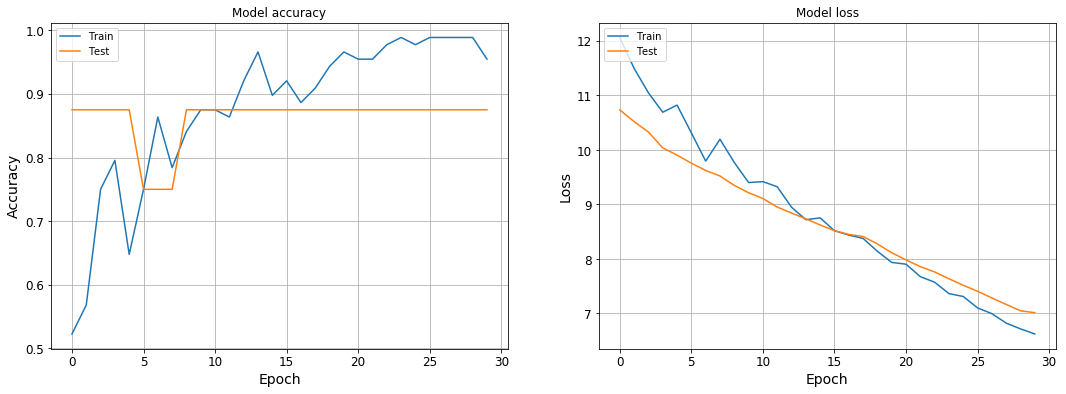

In [89]:
dnn = build_dnn(num_features, num_labels)
history = train_model(dnn, X_train, y_train, X_test, y_test, epochs=30)

> AD vs CN

loss: 3.4295 - acc: 0.8846 - val_loss: 3.9303 - val_acc: 0.8125 - w/ ICV
val_acc = 0.875 -w/o ICV

### Calculating a confusion matrix

Confusion matrix, without normalization
[[5 0]
 [2 9]]


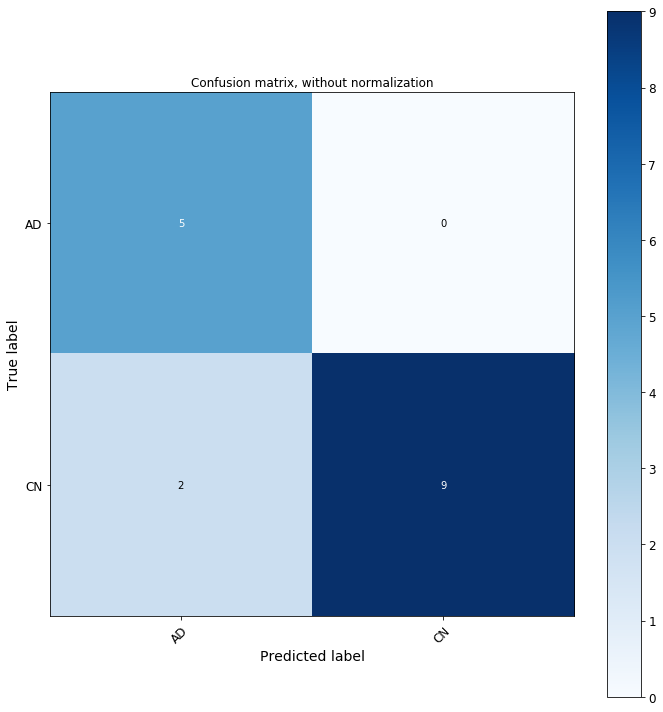

In [81]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

######### Taken from sklearn #######
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=[10,10])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

y_pred_probs = dnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(hot_encoder.transform(y_test.values.reshape(-1,1)), axis=1)
plot_confusion_matrix(y_true, y_pred, classes=hot_encoder.categories_[0])

In [48]:
hot_encoder.categories_[0]

array(['AD', 'CN', 'MCI'], dtype=object)

In [97]:
loss_and_metrics = dnn.evaluate(features, labels_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

201/201 [==============================] - 0s 36us/step
Scores on test set: loss=4.067 accuracy=0.3433


In [82]:
features.shape

(76, 148)

## Using K=10 Fold Cross Validation

Original:  (68, 148)
After Data Augmentation:  (88, 148)
Train on 88 samples, validate on 8 samples
Epoch 1/30
88/88 [==============================] - 0s 5ms/step - loss: 12.0637 - acc: 0.5227 - val_loss: 10.7355 - val_acc: 0.8750
Epoch 2/30
88/88 [==============================] - 0s 107us/step - loss: 11.4965 - acc: 0.5682 - val_loss: 10.5203 - val_acc: 0.8750
Epoch 3/30
88/88 [==============================] - 0s 112us/step - loss: 11.0486 - acc: 0.7500 - val_loss: 10.3292 - val_acc: 0.8750
Epoch 4/30
88/88 [==============================] - 0s 118us/step - loss: 10.6919 - acc: 0.7955 - val_loss: 10.0381 - val_acc: 0.8750
Epoch 5/30
88/88 [==============================] - 0s 144us/step - loss: 10.8228 - acc: 0.6477 - val_loss: 9.9057 - val_acc: 0.8750
Epoch 6/30
88/88 [==============================] - 0s 134us/step - loss: 10.3141 - acc: 0.7500 - val_loss: 9.7574 - val_acc: 0.7500
Epoch 7/30
88/88 [==============================] - 0s 150us/step - loss: 9.7957 - acc: 0.8636 - val

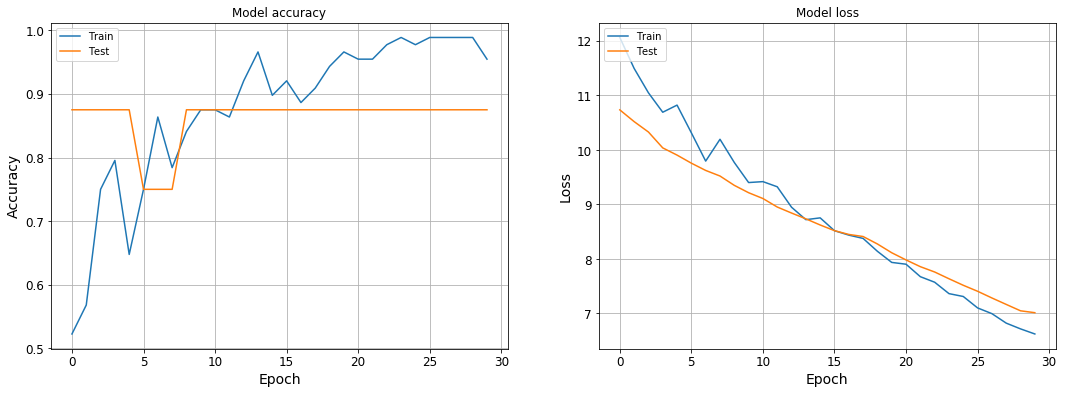

0.9545454464175485 0.875
Original:  (68, 148)
After Data Augmentation:  (90, 148)
Train on 90 samples, validate on 8 samples
Epoch 1/30
90/90 [==============================] - 0s 5ms/step - loss: 12.1526 - acc: 0.5444 - val_loss: 10.6222 - val_acc: 0.6250
Epoch 2/30
90/90 [==============================] - 0s 111us/step - loss: 11.4961 - acc: 0.6778 - val_loss: 10.4617 - val_acc: 0.7500
Epoch 3/30
90/90 [==============================] - 0s 124us/step - loss: 11.1072 - acc: 0.6889 - val_loss: 10.3024 - val_acc: 0.7500
Epoch 4/30
90/90 [==============================] - 0s 129us/step - loss: 10.5207 - acc: 0.7889 - val_loss: 10.1989 - val_acc: 0.7500
Epoch 5/30
90/90 [==============================] - 0s 125us/step - loss: 10.8602 - acc: 0.7222 - val_loss: 10.0859 - val_acc: 0.7500
Epoch 6/30
90/90 [==============================] - 0s 139us/step - loss: 10.2789 - acc: 0.7556 - val_loss: 9.9687 - val_acc: 0.7500
Epoch 7/30
90/90 [==============================] - 0s 131us/step - loss: 

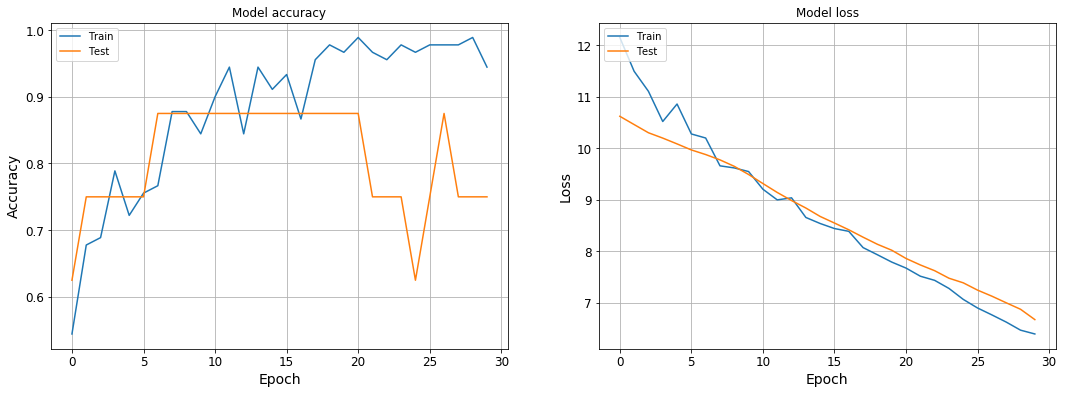

0.9444444311989678 0.75
Original:  (68, 148)
After Data Augmentation:  (86, 148)
Train on 86 samples, validate on 8 samples
Epoch 1/30
86/86 [==============================] - 0s 6ms/step - loss: 12.2978 - acc: 0.5116 - val_loss: 10.6484 - val_acc: 0.6250
Epoch 2/30
86/86 [==============================] - 0s 114us/step - loss: 11.2058 - acc: 0.6395 - val_loss: 10.6112 - val_acc: 0.6250
Epoch 3/30
86/86 [==============================] - 0s 113us/step - loss: 10.8737 - acc: 0.6977 - val_loss: 10.5234 - val_acc: 0.7500
Epoch 4/30
86/86 [==============================] - 0s 116us/step - loss: 10.6954 - acc: 0.7093 - val_loss: 10.4477 - val_acc: 0.7500
Epoch 5/30
86/86 [==============================] - 0s 153us/step - loss: 10.5924 - acc: 0.7907 - val_loss: 10.3771 - val_acc: 0.7500
Epoch 6/30
86/86 [==============================] - 0s 136us/step - loss: 10.1691 - acc: 0.7674 - val_loss: 10.2439 - val_acc: 0.7500
Epoch 7/30
86/86 [==============================] - 0s 134us/step - loss: 

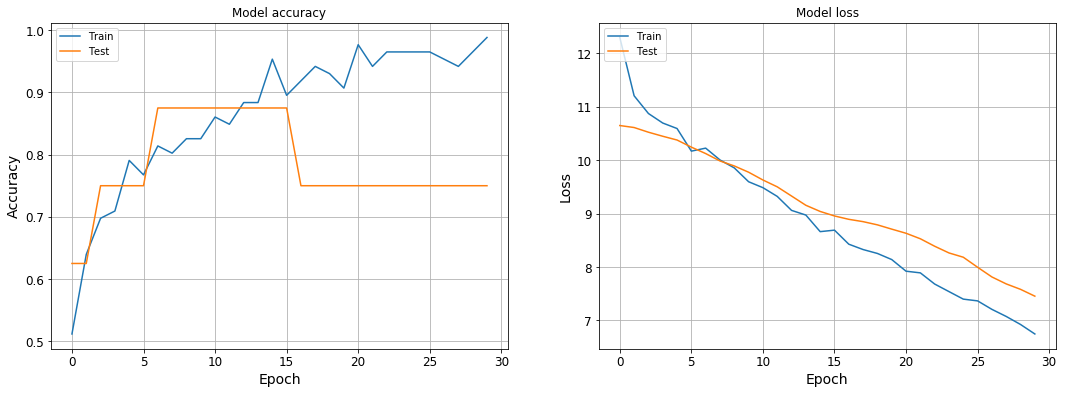

0.9883720902509467 0.75
Original:  (68, 148)
After Data Augmentation:  (88, 148)
Train on 88 samples, validate on 8 samples
Epoch 1/30
88/88 [==============================] - 0s 5ms/step - loss: 12.1015 - acc: 0.5568 - val_loss: 10.5392 - val_acc: 0.7500
Epoch 2/30
88/88 [==============================] - 0s 121us/step - loss: 11.5354 - acc: 0.5568 - val_loss: 10.2436 - val_acc: 0.8750
Epoch 3/30
88/88 [==============================] - 0s 119us/step - loss: 11.2958 - acc: 0.6932 - val_loss: 10.0754 - val_acc: 0.8750
Epoch 4/30
88/88 [==============================] - 0s 115us/step - loss: 10.7566 - acc: 0.7500 - val_loss: 9.9554 - val_acc: 0.8750
Epoch 5/30
88/88 [==============================] - 0s 128us/step - loss: 10.7139 - acc: 0.6932 - val_loss: 9.8053 - val_acc: 0.8750
Epoch 6/30
88/88 [==============================] - 0s 149us/step - loss: 10.6759 - acc: 0.7045 - val_loss: 9.6955 - val_acc: 0.8750
Epoch 7/30
88/88 [==============================] - 0s 140us/step - loss: 9.8

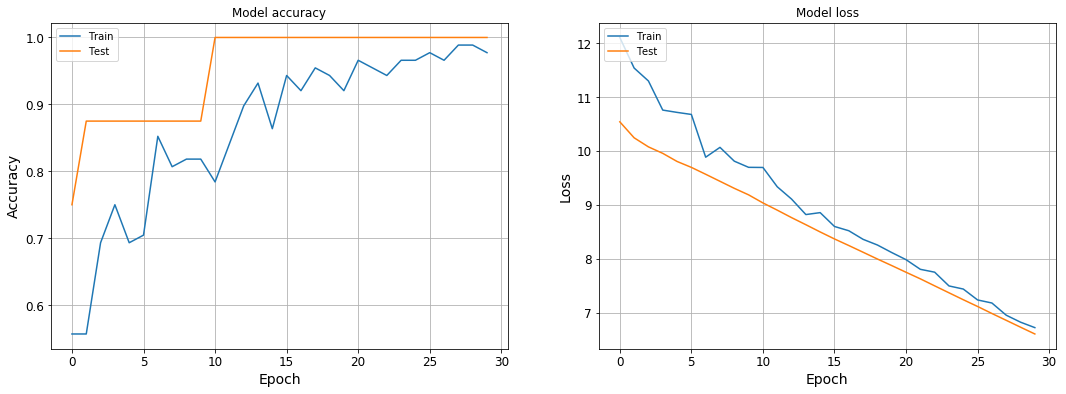

0.9772727218541232 1.0
Original:  (68, 148)
After Data Augmentation:  (90, 148)
Train on 90 samples, validate on 8 samples
Epoch 1/30
90/90 [==============================] - 0s 5ms/step - loss: 12.0812 - acc: 0.5333 - val_loss: 10.7493 - val_acc: 0.6250
Epoch 2/30
90/90 [==============================] - 0s 120us/step - loss: 11.4235 - acc: 0.7000 - val_loss: 10.6780 - val_acc: 0.6250
Epoch 3/30
90/90 [==============================] - 0s 127us/step - loss: 11.1131 - acc: 0.7222 - val_loss: 10.6370 - val_acc: 0.6250
Epoch 4/30
90/90 [==============================] - 0s 136us/step - loss: 10.7252 - acc: 0.7444 - val_loss: 10.5122 - val_acc: 0.7500
Epoch 5/30
90/90 [==============================] - 0s 122us/step - loss: 10.8254 - acc: 0.6889 - val_loss: 10.4643 - val_acc: 0.6250
Epoch 6/30
90/90 [==============================] - 0s 124us/step - loss: 10.1828 - acc: 0.7778 - val_loss: 10.3467 - val_acc: 0.6250
Epoch 7/30
90/90 [==============================] - 0s 134us/step - loss: 1

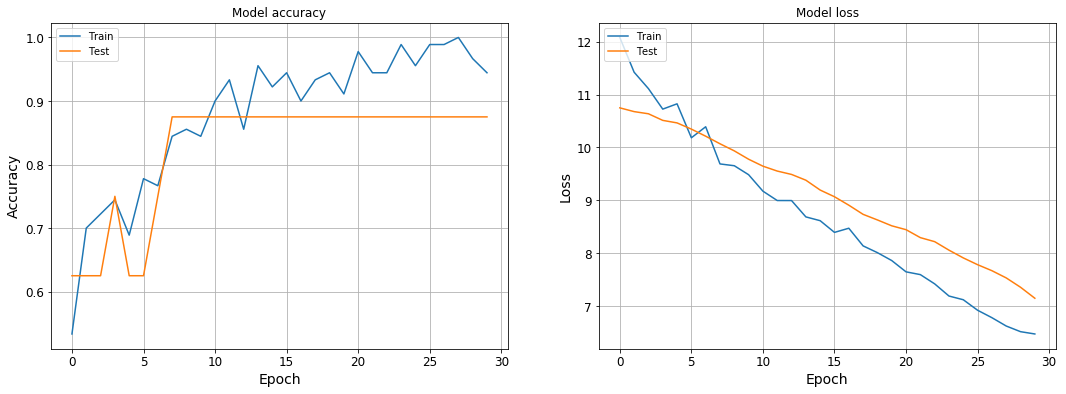

0.9444444311989678 0.875
Original:  (68, 148)
After Data Augmentation:  (92, 148)
Train on 92 samples, validate on 8 samples
Epoch 1/30
92/92 [==============================] - 0s 5ms/step - loss: 11.9155 - acc: 0.5761 - val_loss: 10.5170 - val_acc: 0.8750
Epoch 2/30
92/92 [==============================] - 0s 138us/step - loss: 11.4016 - acc: 0.6087 - val_loss: 10.4841 - val_acc: 0.8750
Epoch 3/30
92/92 [==============================] - 0s 116us/step - loss: 10.8539 - acc: 0.6957 - val_loss: 10.4071 - val_acc: 0.8750
Epoch 4/30
92/92 [==============================] - 0s 123us/step - loss: 10.8421 - acc: 0.7391 - val_loss: 10.2304 - val_acc: 0.8750
Epoch 5/30
92/92 [==============================] - 0s 140us/step - loss: 10.5136 - acc: 0.7717 - val_loss: 10.0755 - val_acc: 0.8750
Epoch 6/30
92/92 [==============================] - 0s 126us/step - loss: 10.3115 - acc: 0.7500 - val_loss: 9.9888 - val_acc: 0.8750
Epoch 7/30
92/92 [==============================] - 0s 142us/step - loss: 

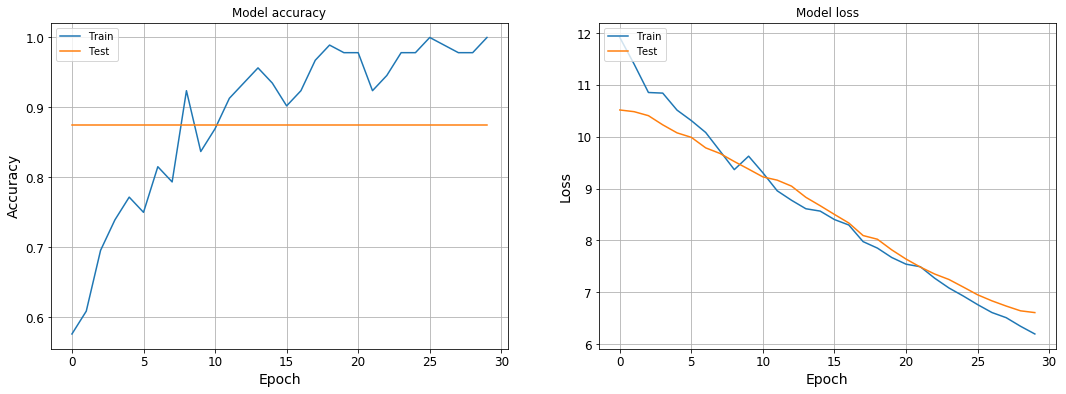

1.0 0.875
Original:  (69, 148)
After Data Augmentation:  (98, 148)
Train on 98 samples, validate on 7 samples
Epoch 1/30
98/98 [==============================] - 0s 5ms/step - loss: 12.2569 - acc: 0.5102 - val_loss: 11.0569 - val_acc: 0.5714
Epoch 2/30
98/98 [==============================] - 0s 117us/step - loss: 11.3409 - acc: 0.6224 - val_loss: 10.8605 - val_acc: 0.8571
Epoch 3/30
98/98 [==============================] - 0s 126us/step - loss: 11.1097 - acc: 0.6122 - val_loss: 10.8560 - val_acc: 0.8571
Epoch 4/30
98/98 [==============================] - 0s 114us/step - loss: 10.7153 - acc: 0.7959 - val_loss: 10.5910 - val_acc: 0.8571
Epoch 5/30
98/98 [==============================] - 0s 109us/step - loss: 10.4597 - acc: 0.7551 - val_loss: 10.3928 - val_acc: 0.8571
Epoch 6/30
98/98 [==============================] - 0s 137us/step - loss: 10.1614 - acc: 0.7857 - val_loss: 10.2970 - val_acc: 0.8571
Epoch 7/30
98/98 [==============================] - 0s 127us/step - loss: 9.7924 - acc: 

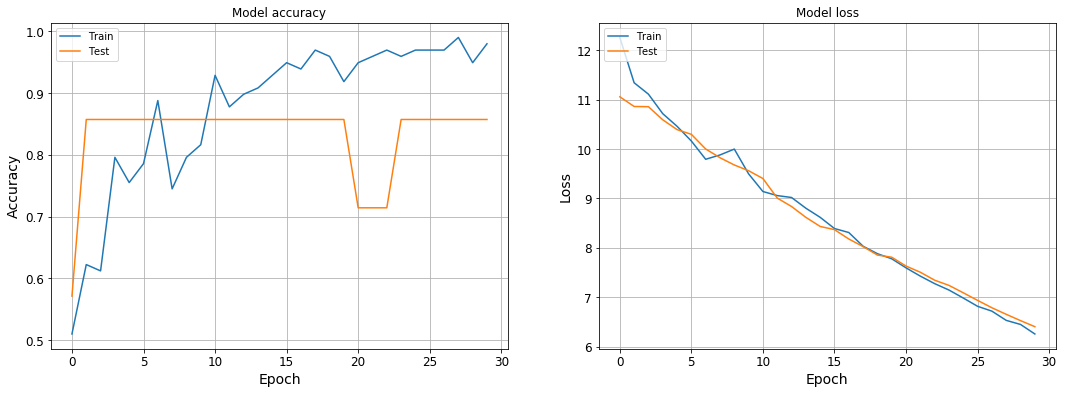

0.979591829436166 0.8571428656578064
Original:  (69, 148)
After Data Augmentation:  (92, 148)
Train on 92 samples, validate on 7 samples
Epoch 1/30
92/92 [==============================] - 0s 5ms/step - loss: 11.4998 - acc: 0.6196 - val_loss: 11.2266 - val_acc: 0.5714
Epoch 2/30
92/92 [==============================] - 0s 118us/step - loss: 11.4372 - acc: 0.6196 - val_loss: 11.2501 - val_acc: 0.5714
Epoch 3/30
92/92 [==============================] - 0s 126us/step - loss: 10.8765 - acc: 0.6957 - val_loss: 10.9742 - val_acc: 0.7143
Epoch 4/30
92/92 [==============================] - 0s 130us/step - loss: 10.8293 - acc: 0.7283 - val_loss: 10.6607 - val_acc: 0.7143
Epoch 5/30
92/92 [==============================] - 0s 115us/step - loss: 10.6894 - acc: 0.7717 - val_loss: 10.5362 - val_acc: 0.8571
Epoch 6/30
92/92 [==============================] - 0s 145us/step - loss: 10.3994 - acc: 0.7500 - val_loss: 10.4898 - val_acc: 0.8571
Epoch 7/30
92/92 [==============================] - 0s 128us/

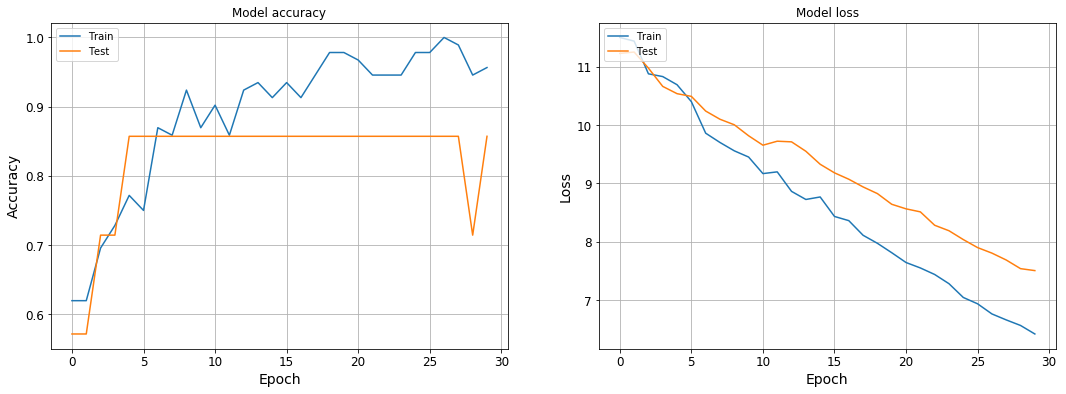

0.9565217313559159 0.8571428656578064
Original:  (69, 148)
After Data Augmentation:  (90, 148)
Train on 90 samples, validate on 7 samples
Epoch 1/30
90/90 [==============================] - 0s 5ms/step - loss: 11.8317 - acc: 0.5222 - val_loss: 11.9788 - val_acc: 0.2857
Epoch 2/30
90/90 [==============================] - 0s 130us/step - loss: 11.4479 - acc: 0.5889 - val_loss: 11.9209 - val_acc: 0.4286
Epoch 3/30
90/90 [==============================] - 0s 131us/step - loss: 10.9658 - acc: 0.6667 - val_loss: 11.6623 - val_acc: 0.4286
Epoch 4/30
90/90 [==============================] - 0s 129us/step - loss: 10.6392 - acc: 0.7667 - val_loss: 11.5432 - val_acc: 0.5714
Epoch 5/30
90/90 [==============================] - 0s 116us/step - loss: 11.0683 - acc: 0.6889 - val_loss: 10.9319 - val_acc: 0.5714
Epoch 6/30
90/90 [==============================] - 0s 145us/step - loss: 10.3865 - acc: 0.7667 - val_loss: 10.5093 - val_acc: 0.5714
Epoch 7/30
90/90 [==============================] - 0s 132us

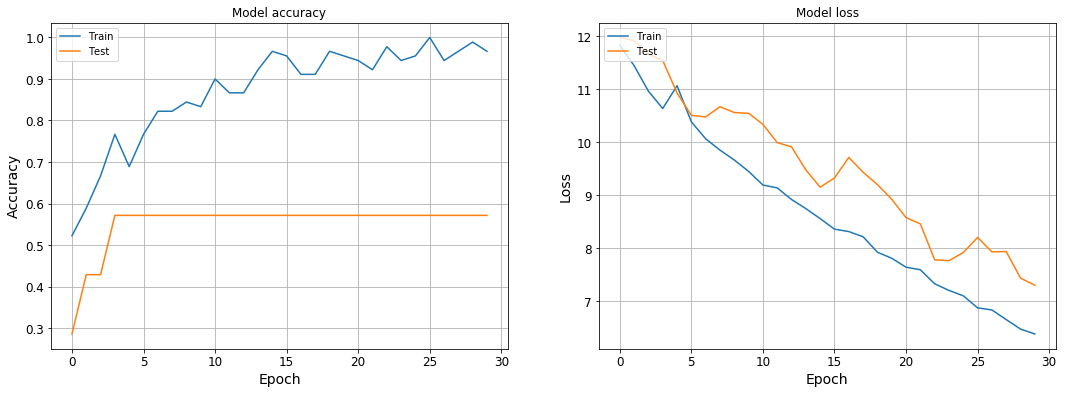

0.9666666587193807 0.5714285969734192
Original:  (69, 148)
After Data Augmentation:  (86, 148)
Train on 86 samples, validate on 7 samples
Epoch 1/30
86/86 [==============================] - 0s 6ms/step - loss: 12.0789 - acc: 0.5814 - val_loss: 10.6092 - val_acc: 0.7143
Epoch 2/30
86/86 [==============================] - 0s 139us/step - loss: 11.7540 - acc: 0.6279 - val_loss: 10.5574 - val_acc: 0.7143
Epoch 3/30
86/86 [==============================] - 0s 126us/step - loss: 10.9565 - acc: 0.6977 - val_loss: 10.5444 - val_acc: 0.7143
Epoch 4/30
86/86 [==============================] - 0s 127us/step - loss: 10.7665 - acc: 0.6860 - val_loss: 10.6230 - val_acc: 0.7143
Epoch 5/30
86/86 [==============================] - 0s 156us/step - loss: 10.5667 - acc: 0.7442 - val_loss: 10.5404 - val_acc: 0.7143
Epoch 6/30
86/86 [==============================] - 0s 145us/step - loss: 10.3290 - acc: 0.7558 - val_loss: 10.4591 - val_acc: 0.7143
Epoch 7/30
86/86 [==============================] - 0s 146us

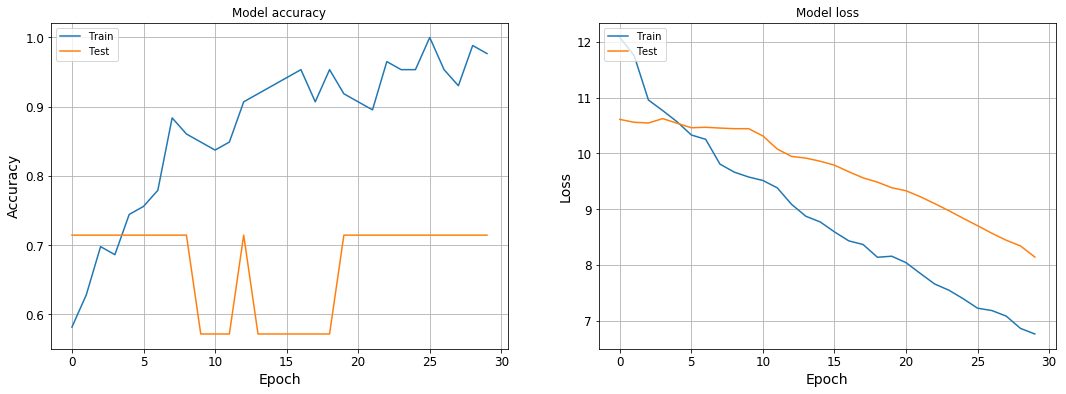

0.976744181888048 0.7142857313156128


In [90]:
def getKF(X,y, n_splits=10):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=n_splits) #Default = 10

    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y.iloc[train_index]
        X_test = X[test_index]
        y_test = y.iloc[test_index]
        
        yield X_train, y_train, X_test, y_test, test_index

histories = []
testing_indxs =[]
zoo = []
for X_train, y_train, X_test, y_test, test_index in getKF(features, labels):
    dnn = build_dnn(num_features, num_labels)
    history = train_model(dnn,X_train, y_train, X_test, y_test)
    histories.append(history)
    testing_indxs.append(test_index)
    zoo.append(dnn)
    print(history.history["acc"][-1], history.history["val_acc"][-1])

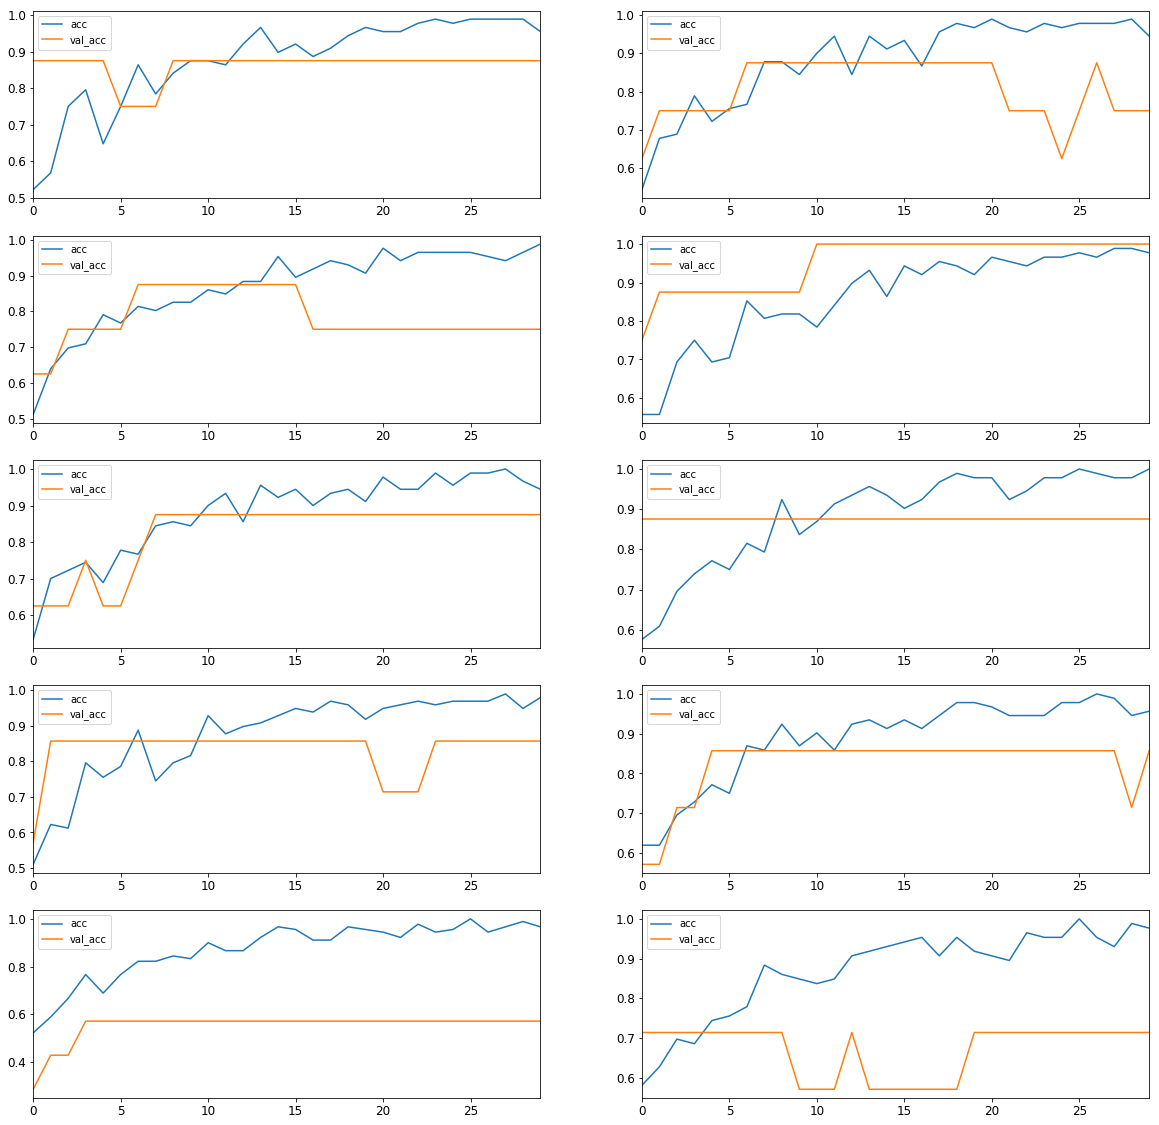

In [92]:
fig, axs = plt.subplots(len(histories)//2,2, figsize=(20,20))
axs=axs.flatten()
dfs = []

for i,history in enumerate(histories):
    df = pd.DataFrame(history.history)
    dfs.append(df)
    df[["acc","val_acc"]].plot(ax=axs[i])

Average: 0.8125000059604645


[0.875,
 0.75,
 0.75,
 1.0,
 0.875,
 0.875,
 0.8571428656578064,
 0.8571428656578064,
 0.5714285969734192,
 0.7142857313156128]

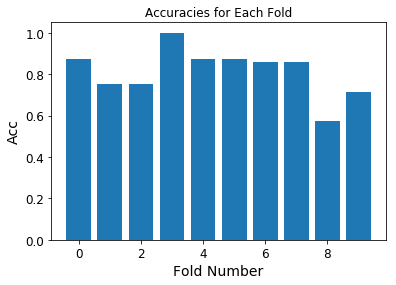

In [93]:
val_accs = [df["val_acc"].iloc[-1] for df in dfs]
print("Average:",np.mean(val_accs))
plt.bar(x=range(10),height=val_accs)
# plt.scatter(x=range(10), y=np.mean(val_accs))
plt.xlabel("Fold Number")
plt.ylabel("Acc")
plt.title("Accuracies for Each Fold")
val_accs

In [44]:
testing_indxs

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69]),
 array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])]

# Evaluating on non SMOTE Samples

In [46]:
# def get_correct_predictions(model,X,y):

model = dnn

samples = scaler.fit_transform(stripped_features) # Note that features is no longer a dataframe

hot_enc = OneHotEncoder(categories="auto", sparse=False)
sample_labels = hot_enc.fit_transform([[label] for label in stripped_labels])
print("Categories:", enc.categories_)

predictions = model.predict(samples)
preds = np.array([np.argmax(x) for x in predictions])
correct = np.array([np.argmax(x) for x in sample_labels])
test_idxs = preds == correct
correct == 0

Categories: [array(['AD', 'CN'], dtype=object)]


array([False, False,  True,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True,  True,
       False,  True, False, False,  True, False, False,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False])

In [58]:
loss_and_metrics = model.evaluate(samples, sample_labels)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

76/76 [==============================] - 0s 55us/step
Scores on test set: loss=7.494 accuracy=1.0000


# LRP

In [97]:
import innvestigate
import innvestigate.utils as iutils


def perform_analysis(model, analyzer, data, labels):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
#     header = "{:^30} {} {}".format("Relevances","Pred", "Actual")
#     print(header)
    
#     for rel,pred,actual in zip(analysis,prediction, labels):
# #         print(np.argmax(pred), actual)
#         result = "{} {:d} {:d}".format(np.around(rel,4), np.argmax(pred), np.argmax(actual))
#         print(result)
    df_anal = pd.DataFrame(analysis)
#     print()
#     print(df_anal.describe())
    return df_anal

# Selecting a DNN
test_dnn = dnn#zoo[2]

# Getting population to analyze
# Select samples with correct prediction
test_idx = correct == 1    #get_correct_predictions() 
test_samples = samples[test_idx] #features[test_idx]
test_labels = sample_labels[test_idx] #labels_1hot[test_idx]

# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(test_dnn)

# Creating an analyzer
gradient_analyzer = innvestigate.analyzer.Gradient(model_wo_sm)
lrp = innvestigate.create_analyzer("lrp.z", model_wo_sm)


# perform_analysis(nn,gradient_analyzer,flowers,types)
lrp_results = perform_analysis(dnn,lrp,test_samples, test_labels)

In [98]:
lrp_results.shape

(50, 148)

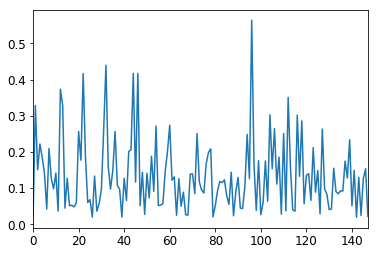

In [99]:
population = abs(lrp_results).mean()
population.plot()

In [100]:
sorted_features = population.sort_values(ascending=False)
best_features = sorted_features[:6]

In [101]:
best_features.index

Int64Index([96, 32, 46, 44, 22, 12], dtype='int64')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x145205048>,
      dtype=object)

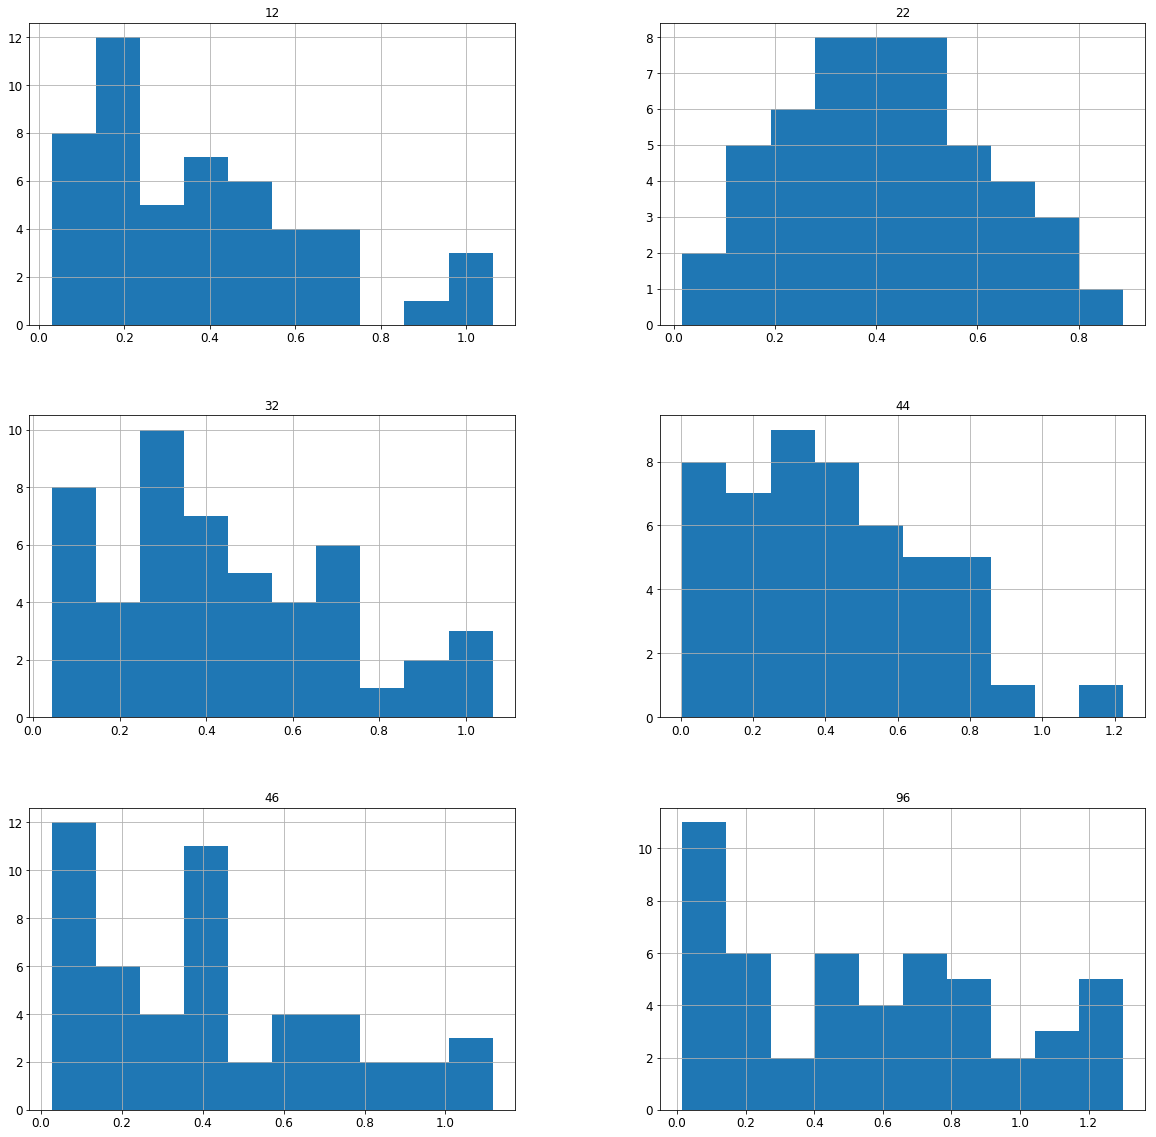

In [104]:
abs(lrp_results)[best_features.index].hist(figsize=(20,20))

In [102]:
raw_features.columns[best_features.index]

Index(['G_oc-temp_med-Parahip_TH_rh', 'G_temp_sup-G_T_transv_TH_lh',
       'S_circular_insula_ant_TH_lh', 'S_central_TH_lh',
       'G_oc-temp_med-Parahip_TH_lh', 'G_front_inf-Orbital_TH_lh'],
      dtype='object')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147]), <a list of 148 Text xticklabel objects>)

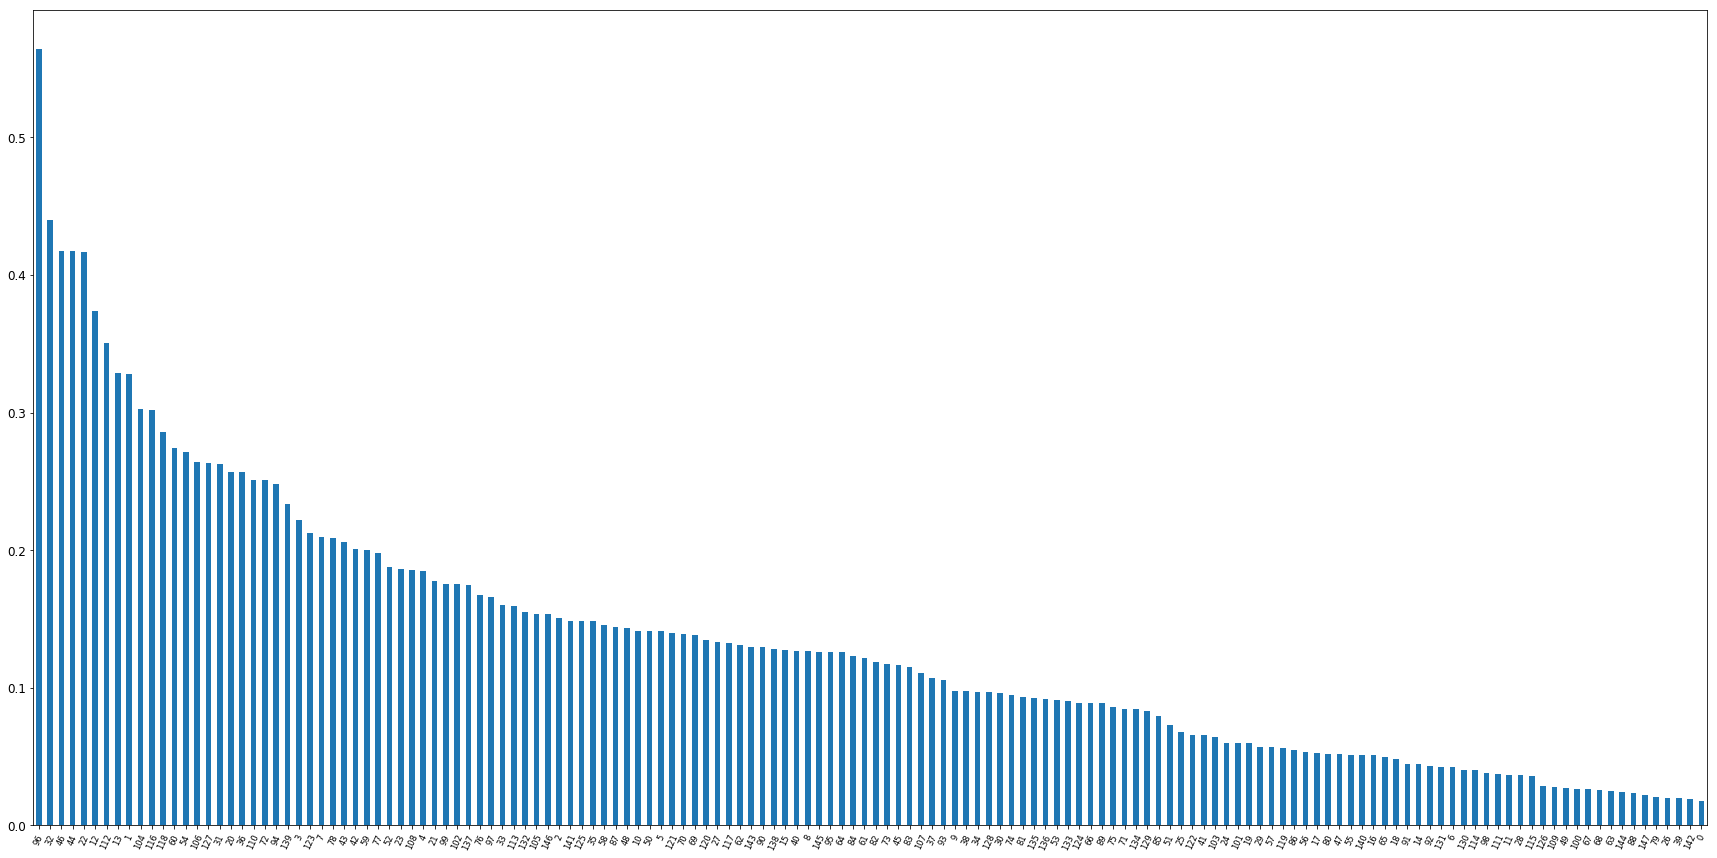

In [103]:
sorted_features.plot(kind="bar", figsize=[30,15])
plt.xticks(rotation=65, fontsize="small")